# Metar plots

In [114]:
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy import feature as cfeature
import pygrib
from scipy.spatial import distance
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

### Load metar data

In [ ]:
Met_20190801 = Dataset( # Aug 1 2019 0300
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/2019_08_01_0300/20190801_0300')
Met_20191101 = Dataset( # Nov 1 2019 0600
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/2019_11_01_0600/20191101_0600')
Met_20200201 = Dataset( # Feb 1 2020 0900
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/2020_02_01_0900/20200201_0900')
Met_20200501 = Dataset( # May 1 2020 1200
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/2020_05_01_1200/20200501_1200')
Met_20200801 = Dataset( # Aug 1 2020 1500
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/2020_08_01_1500/20200801_1500')

### Compile and crop metar data
Swap out the metar file for different plots.

In [ ]:
metar_id = Met_20190801 # Choose your metar
met_gust = metar_id.variables['windGust']
met_lon = metar_id.variables['longitude']
met_lat = metar_id.variables['latitude']
met_temp = metar_id.variables['temperature']
met_windspeed = metar_id.variables['windSpeed']
met_winddir = metar_id.variables['windDir']
met_press = metar_id.variables['seaLevelPress']

top = 49.3457868  # north lat
left = -124.7844079  # west lon
right = -66.9513812  # east lon
bottom = 24.7433195  # south lat

cell = []
for g, lon, lat, t, ws, wd, p in zip(met_gust, met_lon, met_lat, 
                                     met_temp, met_windspeed, met_winddir, met_press):
    if left <= lon <= right and bottom <= lat <= top:
        cell.append((g, lon, lat, t, ws, wd, p))
met_arr = np.asarray(cell)

### Convert metar to dataframe

In [ ]:
met_df = pd.DataFrame(
    {'MetWindGust': met_arr[:, 0],
     'Longitude': met_arr[:, 1],
     'Latitude': met_arr[:, 2],
     'Temperature': met_arr[:, 3],
     'WindSpeed': met_arr[:, 4],
     'WindDirection': met_arr[:, 5],
     'Pressure': met_arr[:, 6]})

met_df = met_df.round(4)
met_df = met_df.replace(np.NaN, 0)

### Limiting to highest gusts
Finding situations where wind gust is greater than 15.6 m/s. "Moderate Risk" for general populace, higher risk for aviation. 

In [ ]:
filtered_values = np.where((met_df['MetWindGust']>=15.6))
high_gust = met_df.loc[filtered_values]

### Making metar plots
One at a time, saved in folder. 

In [ ]:
fig = plt.figure(figsize=(10, 10), facecolor='w')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.scatter(high_gust.Longitude, high_gust.Latitude, c='Red', alpha=0.5,
             vmin=0, vmax=50, s=250, label='Peak Gusts', transform=ccrs.PlateCarree())

plt.title('Aug 1 2020 1500 UTC (9:00AM MDT)')
plt.legend()
plt.show()

# HRRR plots

### Load data

In [134]:
Hrrr_1 = pygrib.open(  # Aug 1 2019 0300
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/2019_08_01_0300/csu_econ.1921300000300.grib2')
Hrrr_2 = pygrib.open(  # Nov 1 2019 0600
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/2019_11_01_0600/csu_econ.1930503000300.grib2')
Hrrr_3 = pygrib.open(  # Feb 1 2019 0900
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/2020_02_01_0900/csu_econ.2003206000300.grib2')
Hrrr_4 = pygrib.open(  # May 1 2019 1200
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/2020_05_01_1200/csu_econ.2012209000300.grib2')
Hrrr_5 = pygrib.open(  # Aug 1 2019 1500
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/2020_08_01_1500/csu_econ.2021412000300.grib2')

### Processing HRRR data
Just replace the inputs (HRRR_#) and rerun. Other HRRR fields will be used for training the neural network. 

In [148]:
hrrr_id = Hrrr_5 # Choose your HRRR
hrrr_gust = hrrr_id[9].values
hrrr_lat, hrrr_lon = hrrr_id[9].latlons()
hrrr_temp = hrrr_id[46].values
hrrr_wind_u = hrrr_id[42].values
hrrr_wind_v = hrrr_id[43].values
hrrr_pressure = hrrr_id[119].values
hrrr_precip_rate = hrrr_id[83].values


hrrr_gust_flat = np.concatenate(hrrr_gust)
hrrr_lat_flat = np.concatenate(hrrr_lat)
hrrr_lon_flat = np.concatenate(hrrr_lon)

cell = []
for g, lon, lat in zip(hrrr_gust_flat, hrrr_lon_flat, hrrr_lat_flat):
    cell.append((g, lon, lat))

hrrr_arr = np.asarray(cell)
np.nan_to_num(hrrr_arr, False, 0)

hrrr_df = pd.DataFrame(
    {'WindGust': hrrr_arr[:,0],
     'Longitude': hrrr_arr[:,1],
     'Latitude': hrrr_arr[:,2]})

hrrr_df = hrrr_df.round(4)

### Limiting to highest gusts

In [149]:
filtered_values = np.where((hrrr_df['WindGust']>=15.6))
hrrr_gust_high = hrrr_df.loc[filtered_values]

### Making HRRR plots

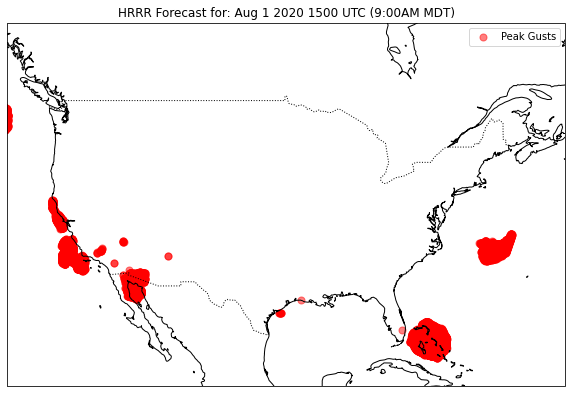

In [150]:
fig = plt.figure(figsize=(10, 10), facecolor='w')
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.scatter(hrrr_gust_high.Longitude, hrrr_gust_high.Latitude, c='Red', alpha=0.5,
             vmin=0, vmax=50, s=50, label='Peak Gusts', transform=ccrs.PlateCarree())

plt.title('HRRR Forecast for: Aug 1 2020 1500 UTC (9:00AM MDT)')
plt.legend()
plt.show()

### Evaluating HRRR performance

Doesn't work yet. 

In [ ]:
def closest_node(metar, hrrrs):
    closest_index = distance.cdist([metar], hrrrs).argmin()
    return hrrrs[closest_index]

hrrr_data = hrrr_arr
lookup_dict = {}

for i in range(0,4394): 
    metar_pt = (round(met_arr[i, 1],3), round(met_arr[i, 2],3))
    metar_gust = met_arr[i, 0]
    hrrr_pt = closest_node(metar_pt, hrrr_data[:, 1:3])
    hrrr_gust = hrrr_data[i, 0]
    lookup_dict[i] = {
        "metar": metar_pt,
        "hrrr": (round(hrrr_pt[0],3), round(hrrr_pt[1],3)),
        "hrrr gust": hrrr_gust,
        "metar gust": metar_gust
    }

In [ ]:
metar_gust = []
hrrr_gust = []

for i in range(0,4394):
    metar_gust.append(lookup_dict[i]['metar gust'])
    hrrr_gust.append(lookup_dict[i]['hrrr gust'])

In [ ]:
print('RMSE:', np.sqrt(
    metrics.mean_squared_error(hrrr_gust, metar_gust)).round(4))

# Neural network plots
In process of being set up

### Training data for neural network

Will actually use HRRR inputs, with a colocated metar output. So it trains on HRRR to predict metar. 

In [ ]:
Met_20170701 = Dataset(  # Metar Training Data
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/20170701_0000')
Met_20180613 = Dataset(  # Metar Training Data
    '/Users/jesseturner/Documents/Wind_Gust_Prediction/Gust_data/20180613_0000')

### Combining training data

In [ ]:
met_gust_1 = Met_20170701.variables['windGust']
met_temp_1 = Met_20170701.variables['temperature']
met_windspeed_1 = Met_20170701.variables['windSpeed']
met_winddir_1 = Met_20170701.variables['windDir']
met_press_1 = Met_20170701.variables['seaLevelPress']

met_gust_2 = Met_20180613.variables['windGust']
met_lon_2 = Met_20180613.variables['longitude']
met_lat_2 = Met_20180613.variables['latitude']
met_temp_2 = Met_20180613.variables['temperature']
met_windspeed_2 = Met_20180613.variables['windSpeed']
met_winddir_2 = Met_20180613.variables['windDir']
met_press_2 = Met_20180613.variables['seaLevelPress']

top = 49.3457868  # north lat
left = -124.7844079  # west lon
right = -66.9513812  # east lon
bottom = 24.7433195  # south lat

cell = []
for g, lon, lat, t, ws, wd, p in zip(met_gust_1, met_lon_1, met_lat_1, 
                                     met_temp_1, met_windspeed_1, met_winddir_1, met_press_1):
    if left <= lon <= right and bottom <= lat <= top:
        cell.append((g, lon, lat, t, ws, wd, p))

for g, lon, lat, t, ws, wd, p in zip(met_gust_2, met_lon_2, met_lat_2, 
                                     met_temp_2, met_windspeed_2, met_winddir_2, met_press_2):
    if left <= lon <= right and bottom <= lat <= top:
        cell.append((g, lon, lat, t, ws, wd, p))

met_pos = np.asarray(cell)

### Making dataframe

In [ ]:
met_df_train = pd.DataFrame(
    {'MetWindGust': met_pos[:, 0],
     'Longitude': met_pos[:, 1],
     'Latitude': met_pos[:, 2],
     'Temperature': met_pos[:, 3],
     'WindSpeed': met_pos[:, 4],
     'WindDirection': met_pos[:, 5],
     'Pressure': met_pos[:, 6]})

met_df_train = met_df_train.round(4)
met_df_train = met_df_train.replace(np.NaN, 0)

### Rescaling and splitting training data

Testing data comes from above. 

In [ ]:
array_train = met_df_train.values
X_train = array_train[:, 1:8]
y = array_train[:, 0]

scaler = StandardScaler()
rescaled_X_train = (scaler.fit_transform(X_train[:, 3:8])) # doesn't include lon, lat

### Training and running neural network

In [ ]:
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                   alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001,
                   power_t=0.5, max_iter=1500, shuffle=True, random_state=None, tol=0.0001, verbose=False,
                   warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False,
                   validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
mlp = mlp.fit(rescaled_X_train, y)

#y_predict_mlp = mlp.predict(rescaled_X_test)

In [ ]:
y_predict_mlp = mlp.predict(rescaled_X_test)